In [1]:
!pip -q install timm

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 9.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requi

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda


In [2]:
PATCH_DS = "/kaggle/input/camelyon-prepro-v4-patches"
SPLIT_DS = "/kaggle/input/split-wsi-level"

PATCH_DIR = os.path.join(PATCH_DS, "patches")
CSV_SPLIT = os.path.join(SPLIT_DS, "patches_metadata_with_split.csv")

OUT_DIR   = "/kaggle/working/embeddings_dinov2"
os.makedirs(OUT_DIR, exist_ok=True)

FEATS_PATH = os.path.join(OUT_DIR, "features.npy")
INDEX_PATH = os.path.join(OUT_DIR, "index.csv")
DONE_PATH  = os.path.join(OUT_DIR, "done.npy")

print("PATCH_DIR:", PATCH_DIR, os.path.exists(PATCH_DIR))
print("CSV_SPLIT:", CSV_SPLIT, os.path.exists(CSV_SPLIT))
print("OUT_DIR:", OUT_DIR)


PATCH_DIR: /kaggle/input/camelyon-prepro-v4-patches/patches True
CSV_SPLIT: /kaggle/input/split-wsi-level/patches_metadata_with_split.csv True
OUT_DIR: /kaggle/working/embeddings_dinov2


In [3]:
df = pd.read_csv(CSV_SPLIT)

# IMPORTANT: patch_path dans le CSV peut pointer vers /kaggle/working (ancienne session)
# On reconstruit le chemin vers le dataset patches.
def fix_patch_path(p):
    # p contient souvent ".../patches/<fname>.png"
    fname = os.path.basename(p)
    return os.path.join(PATCH_DIR, fname)

df["patch_path"] = df["patch_path"].apply(fix_patch_path)

# Vérif existence
missing = (~df["patch_path"].apply(os.path.exists)).sum()
print("Total rows:", len(df), "| missing patch files:", missing)
assert missing == 0, "Certains patchs ne sont pas trouvés dans camelyon-prepro-v4-patches/patches"

# Index à sauver
index_df = df[["patch_path", "wsi_id", "x", "y", "label", "split"]].reset_index(drop=True)
index_df.to_csv(INDEX_PATH, index=False)
print("Saved index:", INDEX_PATH, "shape:", index_df.shape)
index_df.head()


Total rows: 16800 | missing patch files: 0
Saved index: /kaggle/working/embeddings_dinov2/index.csv shape: (16800, 6)


,patch_path,wsi_id,x,y,label,split
0,/kaggle/input/camelyon-prepro-v4-patches/patch...,normal_074,54016,69888,0,train
1,/kaggle/input/camelyon-prepro-v4-patches/patch...,normal_074,18688,74496,0,train
2,/kaggle/input/camelyon-prepro-v4-patches/patch...,normal_074,48640,75776,0,train
3,/kaggle/input/camelyon-prepro-v4-patches/patch...,normal_074,50688,75776,0,train
4,/kaggle/input/camelyon-prepro-v4-patches/patch...,normal_074,50944,75776,0,train


In [4]:
import timm
import torch

model = timm.create_model(
    "vit_base_patch14_dinov2.lvd142m",
    pretrained=True,
    num_classes=0
)

model = model.to(device).eval()

# 🔑 Taille attendue par le modèle
cfg = model.default_cfg
IMG_SIZE = (cfg["input_size"][1], cfg["input_size"][2])
print("Loaded DINOv2 model")
print("Expected IMG_SIZE:", IMG_SIZE)

# 🔍 Vérification dimension embedding
with torch.no_grad():
    dummy = torch.randn(1, 3, IMG_SIZE[0], IMG_SIZE[1]).to(device)
    out = model(dummy)
    EMBED_DIM = out.shape[-1]

print("Embedding dim:", EMBED_DIM)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loaded DINOv2 model
Expected IMG_SIZE: (518, 518)
Embedding dim: 768


In [5]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize(IMG_SIZE),   # ⬅️ taille dynamique correcte
    T.ToTensor(),
    T.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
])

print("Transform ready with IMG_SIZE =", IMG_SIZE)


Transform ready with IMG_SIZE = (518, 518)


In [6]:
class PatchDataset(Dataset):
    def __init__(self, index_df, transform):
        self.df = index_df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        path = self.df.loc[i, "patch_path"]
        img = Image.open(path).convert("RGB")
        x = self.transform(img)
        return x, i  # retourne l'index global i
ds = PatchDataset(index_df, transform)

In [7]:
N = len(index_df)

# init or resume
if os.path.exists(DONE_PATH) and os.path.exists(FEATS_PATH):
    done = np.load(DONE_PATH)
    feats = np.memmap(FEATS_PATH, dtype=np.float16, mode="r+", shape=(N, EMBED_DIM))
    print("Resume: done ratio =", done.mean())
else:
    done = np.zeros(N, dtype=np.uint8)
    feats = np.memmap(FEATS_PATH, dtype=np.float16, mode="w+", shape=(N, EMBED_DIM))
    np.save(DONE_PATH, done)
    print("Fresh start.")

# dataloader
BATCH_SIZE = 16 if device.type == "cuda" else 4
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("BATCH_SIZE:", BATCH_SIZE)


Fresh start.
BATCH_SIZE: 16


In [8]:
# sanity check
X_check, _ = next(iter(loader))
print("Example batch shape:", X_check.shape)


Example batch shape: torch.Size([16, 3, 518, 518])


In [9]:
processed = int(done.sum())

with torch.no_grad():
    for X, idx in tqdm(loader, desc="Extract DINOv2"):
        idx = idx.numpy()
        mask = (done[idx] == 0)
        if not mask.any():
            continue

        X = X[mask].to(device, non_blocking=True)
        idx_keep = idx[mask]

        z = model(X)  # (B, D)
        z = z.detach().cpu().numpy().astype(np.float16)

        feats[idx_keep] = z
        done[idx_keep] = 1
        processed += len(idx_keep)

        if processed % 5000 < len(idx_keep):  # checkpoint périodique
            np.save(DONE_PATH, done)
            feats.flush()

# final save
np.save(DONE_PATH, done)
feats.flush()

print("DONE ratio:", done.mean())
print("Saved feats:", FEATS_PATH)
print("Saved done :", DONE_PATH)
print("Saved index:", INDEX_PATH)

Extract DINOv2: 100%|██████████| 1050/1050 [26:15<00:00,  1.50s/it]

DONE ratio: 1.0
Saved feats: /kaggle/working/embeddings_dinov2/features.npy
Saved done : /kaggle/working/embeddings_dinov2/done.npy
Saved index: /kaggle/working/embeddings_dinov2/index.csv


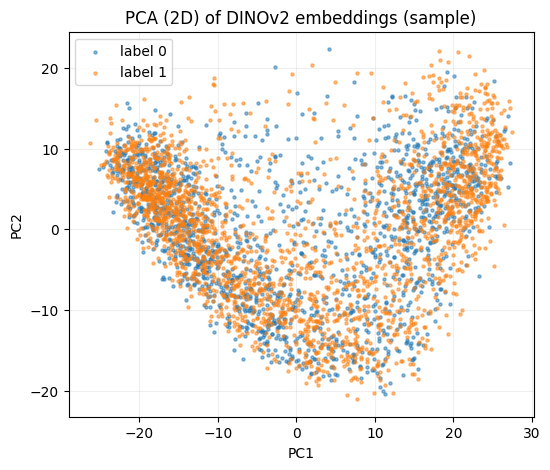

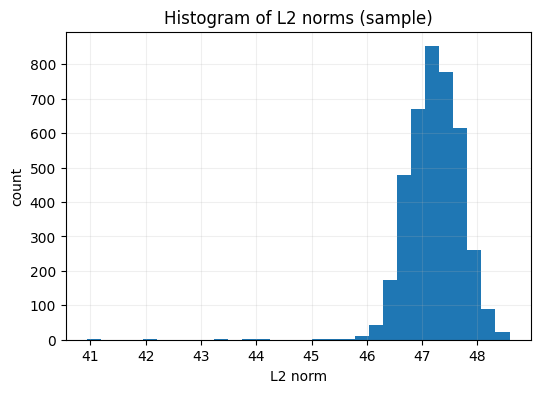

Explained variance ratio: [0.36447823 0.11668114]


In [10]:
from sklearn.decomposition import PCA

# sample
rng = np.random.default_rng(0)
sample_n = min(4000, N)
sample_idx = rng.choice(np.where(done==1)[0], size=sample_n, replace=False)

X = np.array(feats[sample_idx], dtype=np.float32)
y = index_df.loc[sample_idx, "label"].to_numpy()
s = index_df.loc[sample_idx, "split"].to_numpy()

# PCA
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)

plt.figure(figsize=(6,5))
for lab in [0,1]:
    m = (y==lab)
    plt.scatter(Z[m,0], Z[m,1], s=5, alpha=0.5, label=f"label {lab}")
plt.title("PCA (2D) of DINOv2 embeddings (sample)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(alpha=0.2); plt.legend()
plt.show()

# norms
norms = np.linalg.norm(X, axis=1)
plt.figure(figsize=(6,4))
plt.hist(norms, bins=30)
plt.title("Histogram of L2 norms (sample)")
plt.xlabel("L2 norm"); plt.ylabel("count"); plt.grid(alpha=0.2)
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


In [11]:
import os
print("OUT_DIR files:", os.listdir(OUT_DIR))
for f in ["features.npy", "index.csv", "done.npy"]:
    p = os.path.join(OUT_DIR, f)
    print(f, "exists?", os.path.exists(p), "size(MB)=", (os.path.getsize(p)/1e6 if os.path.exists(p) else None))


OUT_DIR files: ['index.csv', 'done.npy', 'features.npy']
features.npy exists? True size(MB)= 25.8048
index.csv exists? True size(MB)= 1.79405
done.npy exists? True size(MB)= 0.016928
